In [366]:
# Import necessary modules
from pathlib import Path
from typing import Optional
import pandas as pd
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchio as tio
from pathlib import Path
from hydra import compose, initialize_config_dir
import logging

In [367]:
# Cell 2: Load Hydra config (without creating working directories)
config_dir = Path("~/vascular-superenhancement-4d-flow/hydra_configs").expanduser().absolute()

with initialize_config_dir(config_dir=str(config_dir), version_base="1.1"):
    cfg = compose(config_name="config", overrides=[
        "train.debug=True",
        "train.patch_size=[64,64,64]", #[128,128,64]
        "train.num_control_points=[12,12,4]", #[6,6,2]
        "train.max_displacement=20", #15
        "train.elastic_deformation_probability=1",
        "data.spacing=[1.4,1.4,1.4]"
    ])

print("Config loaded successfully!")
print(f"Config: {cfg.path_config.path_config_name}" )
print("elastic deformation parameters")
print(f"Number of control points: {cfg.train.num_control_points}")
print(f"Maximum displacement: {cfg.train.max_displacement}")
print(f"Probability of elastic deformation: {cfg.train.elastic_deformation_probability}")
print(f"Patch size: {cfg.train.patch_size}")
print(f"Data spacing: {cfg.data.spacing}")
print(f"Velocity cap: {cfg.data.vel_cap}")
print(f"Data Spacing: {cfg.data.spacing}")

Config loaded successfully!
Config: default
elastic deformation parameters
Number of control points: [12, 12, 4]
Maximum displacement: 20
Probability of elastic deformation: 1
Patch size: [64, 64, 64]
Data spacing: [1.4, 1.4, 1.4]
Velocity cap: 1500
Data Spacing: [1.4, 1.4, 1.4]


In [368]:
from vascular_superenhancement.utils.path_config import load_path_config

# Load path config but don't create Patient object
path_config = load_path_config(cfg.path_config.path_config_name)
print(f"Path config: {path_config.working_dir}")

# Create a mock subject with real data paths
# Replace with actual patient ID and paths from your data
patient_id = "Phidecro"  # Replace with your actual patient ID
time_index = 0

# Construct paths manually (adjust these to your actual data structure)
data_base = path_config.working_dir / "patient_data" / patient_id / "nifti"

# Create mock subject with your actual data structure
mock_subject = tio.Subject(
    mag=tio.ScalarImage(data_base / f"4d_flow_mag_{patient_id}_per_timepoint" / f"4d_flow_mag_{patient_id}_frame_{time_index:02d}.nii.gz"),
    flow_vx=tio.ScalarImage(data_base / f"4d_flow_vx_{patient_id}_per_timepoint" / f"4d_flow_vx_{patient_id}_frame_{time_index:02d}.nii.gz"),  
    flow_vy=tio.ScalarImage(data_base / f"4d_flow_vy_{patient_id}_per_timepoint" / f"4d_flow_vy_{patient_id}_frame_{time_index:02d}.nii.gz"),
    flow_vz=tio.ScalarImage(data_base / f"4d_flow_vz_{patient_id}_per_timepoint" / f"4d_flow_vz_{patient_id}_frame_{time_index:02d}.nii.gz"),
    cine=tio.ScalarImage(data_base / f"3d_cine_{patient_id}_per_timepoint" / f"3d_cine_{patient_id}_frame_{time_index:02d}.nii.gz"),
    patient_id=patient_id,
    time_index=time_index
)

print(f"Mock subject created for patient: {patient_id}")
print(f"Subject keys: {list(mock_subject.keys())}")
print(f"Subject shape: {mock_subject['mag'].shape}")
print(f"Subject spacing: {mock_subject['mag'].spacing}")


Path config: /home/ayeluru/vascular-superenhancement-4d-flow/working_dir/sample_patients
Mock subject created for patient: Phidecro
Subject keys: ['mag', 'flow_vx', 'flow_vy', 'flow_vz', 'cine', 'patient_id', 'time_index']
Subject shape: (1, 512, 512, 40)
Subject spacing: (0.7421978712081909, 0.7422000169754028, 2.9999923706054688)


In [369]:
from vascular_superenhancement.training.transforms import build_transforms

# Build transforms without augmentations first
transforms_no_aug = build_transforms(cfg, train=False)
print("Transforms (no augmentation):")
print(transforms_no_aug)

# Build transforms with augmentations
transforms_with_aug = build_transforms(cfg, train=True)
print("\nTransforms (with augmentation):")
print(transforms_with_aug)

Transforms (no augmentation):
Compose([Resample(target=[1.4, 1.4, 1.4], image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None, in_min_max=None), RescaleIntensity(out_min_max=(-1, 1), percentiles=(0, 100), masking_method=None, in_min_max=(-1500, 1500))])

Transforms (with augmentation):
Compose([Resample(target=[1.4, 1.4, 1.4], image_interpolation=linear, label_interpolation=nearest, pre_affine_name=None, scalars_only=False), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None, in_min_max=None), RescaleIntensity(out_min_max=(-1, 1), percentiles=(0, 100), masking_method=None, in_min_max=(-1500, 1500)), RandomElasticDeformation(), Clamp(out_min=0, out_max=1), Clamp(out_min=-1, out_max=1)])


In [370]:
# from vascular_superenhancement.training.datasets import build_subjects_dataset
from torchio import SubjectsDataset


dataset_no_aug = SubjectsDataset([mock_subject], transform=transforms_no_aug)
dataset_with_aug = SubjectsDataset([mock_subject], transform=transforms_with_aug)

print(f"Dataset size (no augmentation): {len(dataset_no_aug)}")
print(f"Dataset size (with augmentation): {len(dataset_with_aug)}")



Dataset size (no augmentation): 1
Dataset size (with augmentation): 1


visualizing mag wo augmentations (shape: (1, 272, 272, 86))


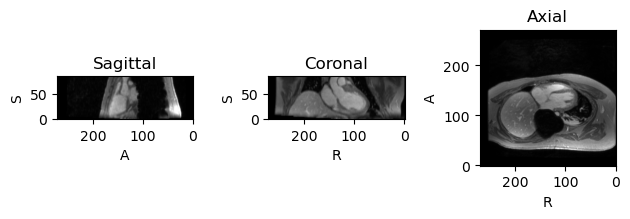

visualizing cine wo augmentations (shape: (1, 272, 272, 86))


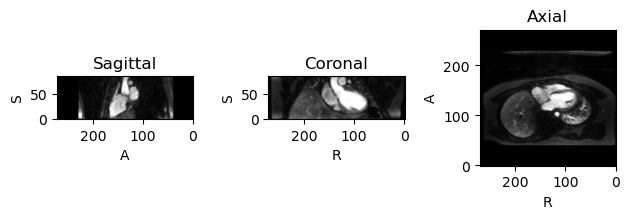

visualizing mag w augmentations (shape: (1, 272, 272, 86))


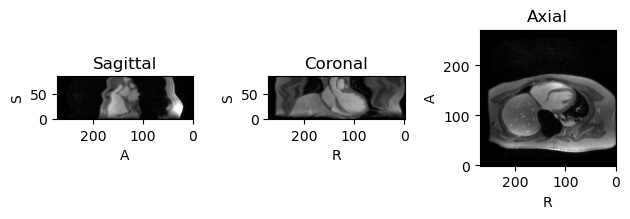

visualizing cine w augmentations (shape: (1, 272, 272, 86))


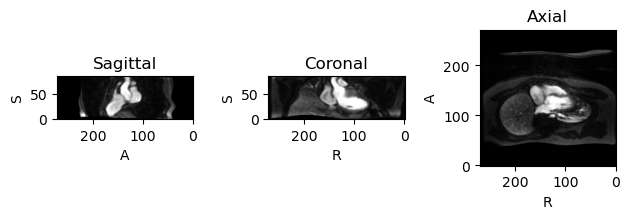

In [371]:
print(f"visualizing mag wo augmentations (shape: {dataset_no_aug[0]['mag'].shape})")
dataset_no_aug[0]['mag'].plot()

print(f"visualizing cine wo augmentations (shape: {dataset_no_aug[0]['cine'].shape})")
dataset_no_aug[0]['cine'].plot()

print(f"visualizing mag w augmentations (shape: {dataset_with_aug[0]['mag'].shape})")
dataset_with_aug[0]['mag'].plot()

print(f"visualizing cine w augmentations (shape: {dataset_with_aug[0]['cine'].shape})")
dataset_with_aug[0]['cine'].plot()




In [372]:
print('done')

done


In [373]:
from vascular_superenhancement.training.dataloading import build_train_loader

loader_no_aug = build_train_loader(dataset_no_aug, cfg)
loader_with_aug = build_train_loader(dataset_with_aug, cfg)

print(f"loader size (no augmentation): {len(loader_no_aug)}")
print(f"loader size (with augmentation): {len(loader_with_aug)}")


loader size (no augmentation): 1
loader size (with augmentation): 1


torch.Size([8, 1, 64, 64, 64])
torch.Size([8, 1, 64, 64, 64])


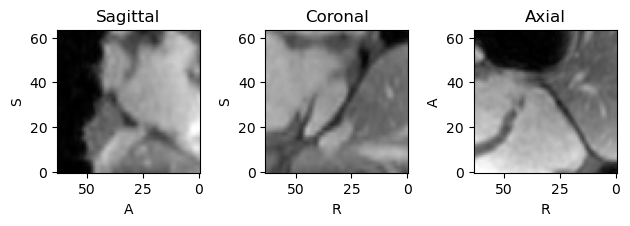

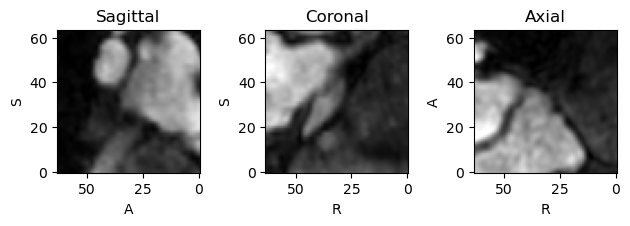

torch.Size([8, 1, 64, 64, 64])
torch.Size([8, 1, 64, 64, 64])


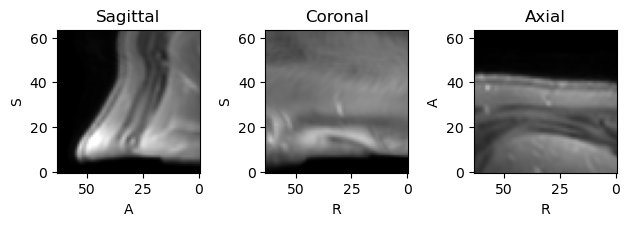

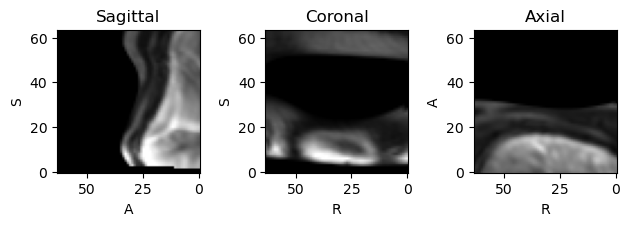

In [379]:
for batch in loader_no_aug:
    # print(f"batch keys: {batch.keys()}")
    inputs = batch['mag'][tio.DATA]
    outputs = batch['cine'][tio.DATA]
    print(inputs.shape)
    print(outputs.shape)
    
    image_input = tio.ScalarImage(tensor=inputs[0])
    image_input.plot()
    
    image_output = tio.ScalarImage(tensor=outputs[0])
    image_output.plot()
    
    break

for batch in loader_with_aug:
    # print(f"batch keys: {batch.keys()}")
    inputs = batch['mag'][tio.DATA]
    outputs = batch['cine'][tio.DATA]
    print(inputs.shape)
    print(outputs.shape)
    
    image_input = tio.ScalarImage(tensor=inputs[0])
    image_input.plot()
    
    image_output = tio.ScalarImage(tensor=outputs[0])
    image_output.plot()
    
    break
